# BioSound Tutorial 5.  Using the Spectrogram as features for classifiers.
### In tutorial 4, you learned how to use predefined acoustical features such as pitch saliency to classify sounds.  Here you will use a spectrogram.  The plotDiscriminate routine performs a PCA on these large feature spaces to prevent over-fitting 

Some things to note:  The spectrogram approach will only work if all BioSound files have the same size spectrogam.  This usually means the same sound length and the same time-frequency scale. Here spectrograms are cut to the smallest soud. It also makes sense to have a logical alignment since the approach will be sensitive to shifts. This code can easily be modified to also use the modulation power spectrum. 
The modulation spectrum allows for variable size sounds and is insensitive to shifts but the analysis window for the MPS must be identical and it must be based on spectrograms that were obtained with the same time-frequency scale.

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas, pickle and sklearn.

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 
from soundsig.discriminate import discriminatePlot
import pickle
from sklearn.decomposition import PCA
from scipy.stats.mstats import zscore

import os


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE  
You will also want to change the location for storing the pandas table.  
Note that you might want to also change the name of the h5 file that stores all of the spectrograms.

In [2]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/frederictheunissen/Documents/Code/BioSoundTutorial/BirdCalls/h5files')

# Some output files
tableStore = '/Users/frederictheunissen/Documents/Code/BioSoundTutorial/vocSelTableSpectro.h5'
pcInfo = '/Users/frederictheunissen/Documents/Code/BioSoundTutorial/vocSpectroPC.pkl'

# This is where you want to store eps of figures that will be generated.
figdir = '/Users/frederictheunissen/Documents/Code/BioSoundTutorial/'

## Step 3. Looping through a set of bioSoundObjects to extract the spectrogram and storing them into a Pandas Data Frame.

#### Part 1. Extract Spectrograms; normalize if desired; and compress by PCA

Here we are doing the PC to store the data efficiently.  Unless you have a ton of data the classifier will only use a small number of these anyway.  The first PCA is to reduce from the ~25000 (for these data) space of spectrogram to a space of 50.  As you will see this is able to capture almost 90% of the variance.

In [3]:
# Set true if you want to normalize all spectrograms.
normFlg = True

#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 50

# Read first one to allocate space for np array
count = 0
shapeSpectro = []
birdName = []
callType = []
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        shapeSpectro.append(myBioSound.spectro.shape)
        birdName.append(np.array2string(myBioSound.emitter)[2:-1])
        callType.append(np.array2string(myBioSound.type)[2:-1])
        
        count += 1
   
shapeSpectro.sort()
shapeDesired = shapeSpectro[0]

X = np.zeros((count, shapeDesired[0]*shapeDesired[1]))
print('Allocated space for all spectrograms') 


Allocated space for all spectrograms


In [4]:
# Loop again to extract spectrogram, store the in X and calculate PC 

# Looping through all the files
count = 0
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        # Massage spectrogram as in matlab code (DFA_Calls_Julie)
        if normFlg:  # Normalize by peak
            myBioSound.spectro -= myBioSound.spectro.max()

        # Set a 100 dB range threshold
        maxAmp = myBioSound.spectro.max();
        minAmp = maxAmp - 100;
        myBioSound.spectro[myBioSound.spectro < minAmp] = minAmp;

        X[count,:] = np.ravel(myBioSound.spectro[0:shapeDesired[0], 0:shapeDesired[1]])
        
        count +=1
            
print('Read %d files and spectrograms' % count)
print('Performing PCA')

pca = PCA(n_components=nPCs)
Xr = pca.fit_transform(X)  
 
# Write PCA information in pkl                         
pcInfoFile = open(pcInfo, 'wb')

pickle.dump(pca.components_, pcInfoFile)

print('PCA Done: Wrote PC\'s to pickle file %s' % pcInfoFile)
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

Read 91 files and spectrograms
Performing PCA
PCA Done: Wrote PC's to pickle file <_io.BufferedWriter name='/Users/frederictheunissen/Documents/Code/BioSoundTutorial/vocSpectroPC.pkl'>
Variance explained is 88.92%


In [5]:
# Make the pandas data frame with all the spectrograms
vocSelData = []
for ic in range(count):         
    vocSelData.append({"Bird": birdName[ic], 
                       "Calltype": callType[ic], 
                       "Spectro": Xr[ic]}) 
     

# Make a panda data frame with all the data  
print('Reprocessed %d files to make Panda Data Frame'%count)                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')
print('Done: Wrote pandas data frame to h5 file %s' % tableStore)

Reprocessed 91 files to make Panda Data Frame
Done: Wrote pandas data frame to h5 file /Users/frederictheunissen/Documents/Code/BioSoundTutorial/vocSelTableSpectro.h5


/Users/frederictheunissen/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['Bird', 'Calltype', 'Spectro']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Step 5.  Run the Classifiers.  
### You can also run only this code after reading vocSelTable

In [6]:
# You can start here (after loading dependencies) or skip if you already have vocSelTable

#Read the pandas table
vocSelTable = pd.read_hdf(tableStore)

In [7]:
# This code is very similar to tutorial 4.

#  Here we generate colors for each bird for plotting purposes:

# Color code for bird ID
birdColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]



birdNames = np.unique(vocSelTable['Bird'])

# If you have a small number of birds you might want to choose specific colors
birdColor = {}
ib = 0
for birdId in birdNames:
    if ib < 4:
       birdColor[birdId] = birdColorStart[ib] 
    else:
       birdColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBirdAll = []
for birdId in vocSelTable['Bird']:
    cValBirdAll.append(birdColor[birdId])
    
cValBirdAll = np.asarray(cValBirdAll)

Variance explained is 51.53%
LDA Weights:
DFA 0: C3 -0.005; C1 -0.003; C2 -0.003; C0 0.000; C4 0.000; 
DFA 1: C0 -0.003; C3 -0.002; C1 0.001; C2 0.000; C4 0.000; 
DFA 2: C3 0.002; C1 -0.002; C2 0.001; C0 -0.001; C4 -0.000; 


/Users/frederictheunissen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


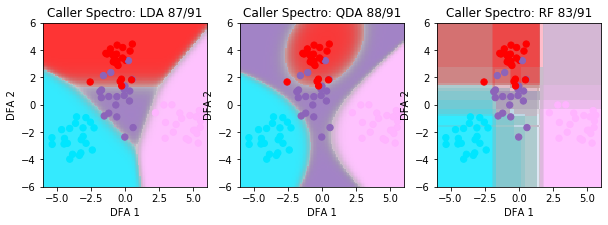

Number of classes 4. Chance level 25.00 %
Caller Spectro LDA: 95.60 % (87/91 p=0.0000)
Caller Spectro QDA: 96.70 % (88/91 p=0.0000)
Caller Spectro RF: 91.21 % (83/91 p=0.0000)


<Figure size 432x288 with 0 Axes>

In [8]:
# This code is very similar to tutorial 4.

#  Now we perform the supervised cross-validated and regularized classification:

# y is the grouping variable
y = np.array(vocSelTable['Bird'])

# X is the vector of features that will be used 
X = np.squeeze(np.array([vocSelTable.loc[:,'Spectro']], dtype=float))

# As always it is wise to exclude entries with missing data (should not happen here)
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)


# The classifier
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                      cValBirdAll[nonanInd], 
                                                                                      titleStr='Caller Spectro', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Spectrogram']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP])}
     
resultsDataFrame = pd.DataFrame(data = d)



In [9]:
resultsDataFrame

,Type,Features,LDA Correct,QDA Correct,RF Correct,Tested,nClasses,LDA Pval,QDA Pval,RF Pval
0,CallerAdult,Spectrogram,87,88,83,91,4,3.585712e-47,5.411474e-49,9.393144e-41


If you compare the results here to those obtained with predefined acoustical features, you see that we do slightly better with the spectrogram.  Note that in both cases we end up describing these sounds with 4 features (here the 4 PCs of the spectrograms)  
Note also that neither here (because we normalized the spectrograms) nor in tutorial 4 (because we did not include the rms) did the classifiers take the sound intentisity as a cue.  The individual signature in the zebra finch distance call is very high.
